In [89]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime, timedelta
from pandas.tseries.offsets import MonthEnd, BDay, Week

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from itertools import product

import time

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from statistics import mean

In [23]:


def plot_predictions(data, train_predictions, test_predictions, scaler):
    """
    Plot actual data along with train and test predictions, using dates on the x-axis.

    Parameters:
    - data: The original DataFrame containing the actual target values.
    - train_predictions: Predicted values for the train dataset (scaled).
    - test_predictions: Predicted values for the test dataset (scaled).
    - scaler: Fitted scaler object used to inverse transform the scaled predictions.
    """
    # Ensure the index is used as the x-axis (datetime index)
    dates = data.index

    # Inverse transform the actual data to the original scale
    actual_data2 = data['Log_Return'].values.reshape(-1, 1)
    actual_data = scaler.inverse_transform(data['Log_Return'].values.reshape(-1, 1))

    # Prepare placeholders for plotting train and test predictions
    train_predict_plot = np.empty_like(actual_data)
    train_predict_plot[:] = np.nan
    train_predict_plot[:len(train_predictions)] = scaler.inverse_transform(train_predictions.reshape(-1, 1))

    test_predict_plot = np.empty_like(actual_data)
    test_predict_plot[:] = np.nan
    test_predict_plot[len(train_predictions):len(train_predictions) + len(test_predictions)] = scaler.inverse_transform(test_predictions.reshape(-1, 1))

    train_dates = data.index[:len(train_predictions)]
    test_dates = data.index[len(train_predictions):len(train_predictions) + len(test_predictions)]

    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Log_Return'], label="Actual Data", color="blue")
    plt.plot(train_dates, scaler.inverse_transform(train_predictions.reshape(-1, 1)), label="Train Predictions", color="orange")
    plt.plot(test_dates, scaler.inverse_transform(test_predictions.reshape(-1, 1)), label="Test Predictions", color="green")
    plt.title("Train and Test Predictions")
    plt.xlabel("Date")
    plt.ylabel("Value (Original Scale)")
    plt.legend()
    plt.grid()
    plt.show()

def calculate_metrics(y_true, y_pred, scaler):
    """
    Calculates RMSE and MAE evaluation metrics before and after inverse transformation.
    
    Parameters:
    - y_true: True values.
    - y_pred: Predicted values.
    - scaler: The target scaler used for inverse transformation.
    
    Returns:
    - RMSE and MAE values before and after inverse transformation.
    """
    # Compute metrics before inverse transformation
    rmse_scaled = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_scaled = mean_absolute_error(y_true, y_pred)
    
    print(f"Scaled RMSE: {rmse_scaled}, Scaled MAE: {mae_scaled}")
    
    # Compute metrics after inverse transformation
    y_true_original = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    rmse_original = np.sqrt(mean_squared_error(y_true_original, y_pred_original))
    mae_original = mean_absolute_error(y_true_original, y_pred_original)
    
    print(f"Original RMSE: {rmse_original}, Original MAE: {mae_original}")
    
    return rmse_original, mae_original

In [139]:

# Step 1: Split the data
def split_data(data, max_lag, sma_windows, train_start, train_end, test_start, test_end):
    """
    Splits the dataset into training and testing sets with lagged log returns and SMA features.
    
    Parameters:
    - data: DataFrame containing stock log returns.
    - max_lag: Maximum number of lagged days for log return features.
    - sma_windows: List of window sizes for SMA features (e.g., [10, 20]).
    - train_start, train_end: Date range for the training dataset.
    - test_start, test_end: Date range for the test dataset.

    Returns:
    - X_train, X_test, y_train, y_test: Scaled train-test feature sets and target values.
    """
    
    # Generate lagged log return features
    for lag in range(1, max_lag + 1):
        data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)

    # Generate SMA features
    for window in sma_windows:
        data[f'SMA_{window}'] = data['Log_Return'].rolling(window=window).mean()

    # Drop rows with NaN values due to lagging and SMA calculation
    data = data.dropna()

    # Split data into train and test sets based on provided dates
    #train_data = data.loc[train_start:train_end]
    #test_data = data.loc[test_start:test_end]
    
    train_size = int(len(data) * 0.75)
    train_data, test_data = data[:train_size], data[train_size:]
    print(train_data.shape)
    print(test_data.shape)
    # Extract features (X) and target (y)
    feature_columns = [f'Lagged_Log_Return_{lag}' for lag in range(1, max_lag + 1)] + \
                      [f'SMA_{window}' for window in sma_windows]
    
    X_train = train_data[feature_columns]
    y_train = train_data['Log_Return']
    X_test = test_data[feature_columns]
    y_test = test_data['Log_Return']

    return X_train, X_test, y_train, y_test


# Step 2: Scale the data

def scale_data(X_train, X_test, y_train, y_test):
    # Create scalers for features and target
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()
    
    # Scale features
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)
    
    # Scale target variable
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler

# Step 3: Model training with hyperparameter tuning
def model_training(train_data_scaled, y_train):
    best_model = None
    best_score = float('-inf')
    best_params = None  # Store the best parameters

    hyperparameters = {
        'cov_type': ['HC0', 'HC1'],
        'use_t': [True, False],
        'method': ['pinv', 'qr']
    }

    for params in product(*hyperparameters.values()):
        try:
            model = sm.OLS(y_train, train_data_scaled)
            fitted_model = model.fit(cov_type=params[0], use_t=params[1], method=params[2])
            if fitted_model.rsquared_adj > best_score:
                best_model = fitted_model
                best_score = fitted_model.rsquared_adj
                best_params = params  # Save the best hyperparameters
        except Exception as e:
            print(f"Error with params {params}: {e}")

    return best_model, best_params


# Step 4: Main workflow


def train_final_model(data, max_lag, sma_windows,feature_scaler, target_scaler, best_params):
    
    X_full, _, y_full, _ = split_data(data, max_lag,sma_windows, "2000-01-01", "2023-12-31", None, None)
    X_full_scaled = feature_scaler.transform(X_full)
    y_full_scaled = target_scaler.transform(y_full.values.reshape(-1, 1))

    final_model = sm.OLS(y_full_scaled, X_full_scaled).fit(
        cov_type=best_params[0],
        use_t=best_params[1],
        method=best_params[2]
    )

    return final_model

In [140]:
def forecast_future(data, model, scaler, max_lag, sma_windows, start_date="2024-01-01", end_date="2024-12-31"):
    """Forecast future log returns using the trained model with lagged returns and SMA features."""
    if model is None:
        raise ValueError("Cannot forecast because the model is not trained.")

    # Get the last available features (Lagged Log Returns + SMA)
    lagged_features = data.iloc[-1, :][[f'Lagged_Log_Return_{i}' for i in range(1, max_lag + 1)]].values
    sma_features = data.iloc[-1, :][[f'SMA_{w}' for w in sma_windows]].values

    future_dates = pd.date_range(start=start_date, end=end_date, freq="B")  
    future_forecasts = pd.DataFrame(index=future_dates)
    future_forecasts['Forecasted_Log_Return'] = np.nan

    for date in future_forecasts.index:
        # Combine lagged features and SMA features
        input_features = np.hstack((lagged_features, sma_features))

        # Predict scaled forecasted return
        forecasted_scaled = model.predict(input_features.reshape(1, -1))[0]

        # Inverse transform to original scale
        forecasted_original = scaler.inverse_transform([[forecasted_scaled]])[0][0]
        future_forecasts.at[date, 'Forecasted_Log_Return'] = forecasted_original

        # Update lagged features (shift left and insert new forecast)
        lagged_features = np.roll(lagged_features, -1)
        lagged_features[-1] = forecasted_scaled  # Use predicted value for next forecast

        # Update SMA values dynamically (simulate moving average)
        new_sma_values = []
        for window in sma_windows:
            recent_returns = np.concatenate(([forecasted_original], data['Log_Return'].values[-(window - 1):]))  # Add new forecast
            new_sma_values.append(np.mean(recent_returns))  # Compute new SMA
        
        sma_features = np.array(new_sma_values)  # Update SMA features for next prediction

    return future_forecasts


In [141]:
def group_forecasts(forecast_df, year):
    """
    Groups the forecasted log returns month-wise and week-wise based on the given year.
    
    Parameters:
    - forecast_df: DataFrame with forecasted log returns indexed by date.
    - year: Year for which weeks should be grouped.
    
    Returns:
    - Dictionary with forecasted log returns per month and per week as lists.
    """
    forecast_df['Month'] = forecast_df.index.to_period('M')
    forecast_df['Week'] = forecast_df.index.to_period('W-SUN')  # Ensure weeks align with trading days
    
    grouped_month_forecast = {f"forecast_predictions_df_{i+1}m": values for i, (key, values) in enumerate(forecast_df.groupby('Month')['Forecasted_Log_Return'].apply(list).items())}
    grouped_week_forecast = {f"forecast_predictions_df_{i+1}w": values for i, (key, values) in enumerate(forecast_df[forecast_df.index.year == year].groupby(pd.Grouper(freq='W-FRI'))['Forecasted_Log_Return'].apply(list).items())}
    
    return grouped_month_forecast, grouped_week_forecast


In [142]:
# Step 7: Main Function
def main(data):
    max_lag = 80
    train_start, train_end = "2000-01-01", "2014-12-31"
    test_start, test_end = "2015-01-01", "2024-01-01"
    sma_windows = [5,10,15]
    # Split Data for Evaluation
    X_train, X_test, y_train, y_test = split_data(data, max_lag,sma_windows, train_start, train_end, test_start, test_end)

    # Scale Data
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler = scale_data(X_train, X_test, y_train, y_test)

    # Train Model on Train Set (`2000-2014`)
    start_time = time.time()    
    best_model, best_params = model_training(X_train_scaled, y_train)
    end_time = time.time()
    computaton_time = end_time - start_time
    print(f"Computation Time: {computaton_time:.2f} seconds")
    
    # Generate Predictions
    train_predictions_scaled = best_model.predict(X_train_scaled)
    test_predictions_scaled = best_model.predict(X_test_scaled)

    
    # Evaluate Train-Test Performance
    train_rmse, train_mae = calculate_metrics(y_train_scaled, train_predictions_scaled, target_scaler)
    test_rmse, test_mae = calculate_metrics(y_test_scaled, test_predictions_scaled, target_scaler)

    print(f"Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}")
    # Step 6: Compute evaluation metrics
    
    model_metrics={
                "training_set":{
                    "mae" : train_mae,
                    "rmse" : train_rmse
                },
                "test_set":{
                    "mae" : test_mae,
                    "rmse" : test_rmse
                },
                "time":computaton_time
                
        }

    #plot_predictions(data, y_train_scaled, y_test_scaled, target_scaler)
    
    # Train Final Model on Full Dataset (`2000-2023`)
    final_model = train_final_model(data, max_lag,sma_windows, feature_scaler, target_scaler, best_params)

    # Forecast Future (`2024`)
    future_predictions = forecast_future(data, final_model, target_scaler, max_lag, sma_windows,start_date="2024-01-01", end_date="2024-12-31" )

    print("Future Predictions:")
    print(future_predictions)

    return final_model, future_predictions, model_metrics

In [143]:
def run_workflow(tickers):
    """
    Runs the workflow for multiple stock tickers.
    """
    results = {}
    
    for ticker in tickers:
        print(f"Processing {ticker}...")
        
        # Step 1: Download data
        data = yf.download(ticker, start="2000-01-01", end="2023-12-31")
        
        # Step 2: Compute log returns
        data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))
        
        # Step 3: Drop NaN values
        data = data.dropna()
        
        # Step 4: Ensure index is datetime
        data.index = pd.to_datetime(data.index)
        
        # Step 5: Run the main function
        final_model, future_predictions, model_metrics = main(data)
        
        # Step 6: Group forecasted returns month-wise and week-wise for 2024
        monthly_forecasts, weekly_forecasts = group_forecasts(future_predictions, year=2024)
        
        # Step 7: Store results in a dictionary
        results[ticker] = {
            #"final_model": final_model,
            #"future_predictions": future_predictions,
            "monthly_forecast_results": monthly_forecasts,
            "weekly_forecast_results": weekly_forecasts,
            "model_metrics": model_metrics
        }
    
    return results

# List of tickers to process
tickers = ['SMH', 'SOXX', 'PSI', 'XSD', 'IYW', 'XLK', 'VGT', 'FTEC', 'IGM', 'IXN']

#tickers = ['SMH', 'SOXX']

#tickers = ['SMH', 'SOXX', 'PSI','XSD', 'IYW', 'XLK', 'VGT',]

# Execute the workflow for multiple tickers
results = run_workflow(tickers)


[*********************100%%**********************]  1 of 1 completed

Processing SMH...
(4387, 90)
(1463, 90)



/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is tryi

/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'SMA_{window}'] = data['Log_Return'].rolling(window=window).mean()
[*********************100%%**********************]  1 of 1 completed

Computation Time: 0.37 seconds
Scaled RMSE: 0.978379695462784, Scaled MAE: 0.6749145074251095
Original RMSE: 0.021153174132583486, Original MAE: 0.014592069077452776
Scaled RMSE: 0.9738856991032153, Scaled MAE: 0.7146504334279866
Original RMSE: 0.021056011151804138, Original MAE: 0.015451184373851814
Train RMSE: 0.0212, Train MAE: 0.0146
Test RMSE: 0.0211, Test MAE: 0.0155
(4387, 90)
(1463, 90)
Future Predictions:
            Forecasted_Log_Return
2024-01-01              -0.000257
2024-01-02              -0.000807
2024-01-03              -0.000119
2024-01-04               0.000135
2024-01-05               0.000323
2024-01-08               0.000761
2024-01-09              -0.000170
2024-01-10              -0.000403
2024-01-11              -0.000716
2024-01-12              -0.001174
2024-01-15              -0.000956
2024-01-16              -0.001220
2024-01-17              -0.000762
2024-01-18              -0.000289
2024-01-19               0.000212
2024-01-22               0.000602
2024


/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is tryi

(4178, 90)
(1393, 90)


/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'SMA_{window}'] = data['Log_Return'].rolling(window=window).mean()
[*********************100%%**********************]  1 of 1 completed

Computation Time: 0.40 seconds
Scaled RMSE: 0.9805548126205728, Scaled MAE: 0.7048298294002852
Original RMSE: 0.01906707206720618, Original MAE: 0.013705548103298262
Scaled RMSE: 1.1156867993759298, Scaled MAE: 0.8135477582969227
Original RMSE: 0.021694738870618374, Original MAE: 0.015819588602196625
Train RMSE: 0.0191, Train MAE: 0.0137
Test RMSE: 0.0217, Test MAE: 0.0158
(4178, 90)
(1393, 90)
Future Predictions:
            Forecasted_Log_Return
2024-01-01              -0.000199
2024-01-02              -0.000793
2024-01-03              -0.000359
2024-01-04              -0.000104
2024-01-05              -0.000111
2024-01-08               0.000329
2024-01-09              -0.000753
2024-01-10              -0.000862
2024-01-11              -0.000980
2024-01-12              -0.001319
2024-01-15              -0.000916
2024-01-16              -0.000955
2024-01-17              -0.000737
2024-01-18              -0.000011
2024-01-19               0.000293
2024-01-22               0.000742
2024


/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is tryi

(3435, 90)
(1146, 90)
Computation Time: 0.34 seconds
Scaled RMSE: 0.9826717112162897, Scaled MAE: 0.7287910785049345
Original RMSE: 0.017028019191538773, Original MAE: 0.012628702271325292
Scaled RMSE: 1.3482832450403057, Scaled MAE: 0.9935338511764824
Original RMSE: 0.02336344143229664, Original MAE: 0.017216241489578076
Train RMSE: 0.0170, Train MAE: 0.0126
Test RMSE: 0.0234, Test MAE: 0.0172
(3435, 90)
(1146, 90)
Future Predictions:
            Forecasted_Log_Return
2024-01-01              -0.000074
2024-01-02              -0.000697
2024-01-03              -0.000406
2024-01-04              -0.000210
2024-01-05              -0.000182
2024-01-08               0.000356
2024-01-09              -0.000646
2024-01-10              -0.000765
2024-01-11              -0.000847
2024-01-12              -0.001222
2024-01-15              -0.000716
2024-01-16              -0.000586
2024-01-17              -0.000425
2024-01-18               0.000228
2024-01-19               0.000473
2024-01-22      

/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'SMA_{window}'] = data['Log_Return'].rolling(window=window).mean()
[*********************100%%**********************]  1 of 1 completed
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/

(3318, 90)
(1107, 90)


/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'SMA_{window}'] = data['Log_Return'].rolling(window=window).mean()
[*********************100%%**********************]  1 of 1 completed

Computation Time: 0.30 seconds
Scaled RMSE: 0.9820232618013451, Scaled MAE: 0.7231405839125784
Original RMSE: 0.017653828875890547, Original MAE: 0.012999895845834577
Scaled RMSE: 1.3184898804629468, Scaled MAE: 0.9865689173770191
Original RMSE: 0.02370248814838651, Original MAE: 0.017735546110892175
Train RMSE: 0.0177, Train MAE: 0.0130
Test RMSE: 0.0237, Test MAE: 0.0177
(3318, 90)
(1107, 90)
Future Predictions:
            Forecasted_Log_Return
2024-01-01              -0.000077
2024-01-02              -0.000746
2024-01-03              -0.000209
2024-01-04               0.000012
2024-01-05               0.000195
2024-01-08               0.000733
2024-01-09              -0.000495
2024-01-10              -0.000813
2024-01-11              -0.000854
2024-01-12              -0.001202
2024-01-15              -0.000715
2024-01-16              -0.000707
2024-01-17              -0.000616
2024-01-18              -0.000025
2024-01-19               0.000261
2024-01-22               0.000514
2024


/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is tryi

/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'SMA_{window}'] = data['Log_Return'].rolling(window=window).mean()
[*********************100%%**********************]  1 of 1 completed

Computation Time: 0.33 seconds
Scaled RMSE: 0.9829688368339173, Scaled MAE: 0.6549976680522123
Original RMSE: 0.016741102647292828, Original MAE: 0.011155372158000807
Scaled RMSE: 1.0107158480018057, Scaled MAE: 0.7124406275902726
Original RMSE: 0.01721366652186425, Original MAE: 0.012133692574636194
Train RMSE: 0.0167, Train MAE: 0.0112
Test RMSE: 0.0172, Test MAE: 0.0121
(4395, 90)
(1465, 90)
Future Predictions:
            Forecasted_Log_Return
2024-01-01              -0.000103
2024-01-02              -0.000279
2024-01-03              -0.000118
2024-01-04              -0.000107
2024-01-05              -0.000162
2024-01-08              -0.000042
2024-01-09              -0.000334
2024-01-10              -0.000343
2024-01-11              -0.000325
2024-01-12              -0.000263
2024-01-15              -0.000380
2024-01-16              -0.000428
2024-01-17              -0.000208
2024-01-18              -0.000209
2024-01-19               0.000071
2024-01-22               0.000318
2024


/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is tryi

/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'SMA_{window}'] = data['Log_Return'].rolling(window=window).mean()
[*********************100%%**********************]  1 of 1 completed

Computation Time: 0.33 seconds
Scaled RMSE: 0.9841582305732169, Scaled MAE: 0.6564782303256989
Original RMSE: 0.01559061531215988, Original MAE: 0.01039964838159633
Scaled RMSE: 1.0546113950254503, Scaled MAE: 0.7373740872636223
Original RMSE: 0.016706704321403188, Original MAE: 0.011681166075282733
Train RMSE: 0.0156, Train MAE: 0.0104
Test RMSE: 0.0167, Test MAE: 0.0117
(4467, 90)
(1489, 90)
Future Predictions:
            Forecasted_Log_Return
2024-01-01              -0.000049
2024-01-02              -0.000202
2024-01-03               0.000006
2024-01-04               0.000009
2024-01-05               0.000012
2024-01-08               0.000107
2024-01-09              -0.000114
2024-01-10              -0.000170
2024-01-11              -0.000261
2024-01-12              -0.000291
2024-01-15              -0.000453
2024-01-16              -0.000491
2024-01-17              -0.000263
2024-01-18              -0.000216
2024-01-19               0.000094
2024-01-22               0.000256
2024-


/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is tryi

/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'SMA_{window}'] = data['Log_Return'].rolling(window=window).mean()
[*********************100%%**********************]  1 of 1 completed

Computation Time: 0.31 seconds
Scaled RMSE: 0.9871364731931158, Scaled MAE: 0.6833950692430854
Original RMSE: 0.012698056484972695, Original MAE: 0.008790870792900859
Scaled RMSE: 1.3315385029522016, Scaled MAE: 0.9326774132770379
Original RMSE: 0.017128281227124, Original MAE: 0.011997520907864517
Train RMSE: 0.0127, Train MAE: 0.0088
Test RMSE: 0.0171, Test MAE: 0.0120
(3699, 90)
(1234, 90)
Future Predictions:
            Forecasted_Log_Return
2024-01-01           2.447591e-04
2024-01-02           1.148383e-04
2024-01-03           2.536096e-04
2024-01-04           2.643799e-04
2024-01-05           2.510077e-04
2024-01-08           3.361217e-04
2024-01-09           8.342725e-05
2024-01-10           4.080405e-05
2024-01-11           1.304303e-07
2024-01-12           2.704839e-05
2024-01-15          -4.158607e-05
2024-01-16           5.103897e-06
2024-01-17           1.609493e-04
2024-01-18           1.790947e-04
2024-01-19           3.868142e-04
2024-01-22           4.750312e-04
2024-0


/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is tryi

/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'SMA_{window}'] = data['Log_Return'].rolling(window=window).mean()
[*********************100%%**********************]  1 of 1 completed

Computation Time: 0.18 seconds
Scaled RMSE: 0.9860769503603137, Scaled MAE: 0.641618934769518
Original RMSE: 0.013729198328416986, Original MAE: 0.008933292278558548
Scaled RMSE: 1.152788988925239, Scaled MAE: 0.8791480229749243
Original RMSE: 0.016050338316889706, Original MAE: 0.012240421564511812
Train RMSE: 0.0137, Train MAE: 0.0089
Test RMSE: 0.0161, Test MAE: 0.0122
(1861, 90)
(621, 90)
Future Predictions:
            Forecasted_Log_Return
2024-01-01               0.000652
2024-01-02               0.000512
2024-01-03               0.000666
2024-01-04               0.000663
2024-01-05               0.000650
2024-01-08               0.000771
2024-01-09               0.000508
2024-01-10               0.000476
2024-01-11               0.000434
2024-01-12               0.000424
2024-01-15               0.000328
2024-01-16               0.000372
2024-01-17               0.000550
2024-01-18               0.000573
2024-01-19               0.000800
2024-01-22               0.000895
2024-0


/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is tryi

/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'SMA_{window}'] = data['Log_Return'].rolling(window=window).mean()
[*********************100%%**********************]  1 of 1 completed

Computation Time: 0.39 seconds
Scaled RMSE: 0.9852346824082849, Scaled MAE: 0.6784941338953
Original RMSE: 0.014544928274985994, Original MAE: 0.010016545995298488
Scaled RMSE: 1.1431960808640924, Scaled MAE: 0.8053240531147525
Original RMSE: 0.016876897755739716, Original MAE: 0.011888924334294821
Train RMSE: 0.0145, Train MAE: 0.0100
Test RMSE: 0.0169, Test MAE: 0.0119
(4239, 90)
(1413, 90)
Future Predictions:
            Forecasted_Log_Return
2024-01-01               0.000162
2024-01-02              -0.000045
2024-01-03               0.000174
2024-01-04               0.000195
2024-01-05               0.000097
2024-01-08               0.000224
2024-01-09              -0.000065
2024-01-10              -0.000117
2024-01-11              -0.000096
2024-01-12              -0.000116
2024-01-15              -0.000200
2024-01-16              -0.000291
2024-01-17              -0.000062
2024-01-18               0.000032
2024-01-19               0.000330
2024-01-22               0.000517
2024-0


/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is tryi

Computation Time: 0.30 seconds
Scaled RMSE: 0.9860981617594763, Scaled MAE: 0.6685409216424953
Original RMSE: 0.013708577134058042, Original MAE: 0.009293947749844619
Scaled RMSE: 1.208654389997533, Scaled MAE: 0.8463692759412704
Original RMSE: 0.016802517818444586, Original MAE: 0.011766088765884732
Train RMSE: 0.0137, Train MAE: 0.0093
Test RMSE: 0.0168, Test MAE: 0.0118
(4110, 90)
(1371, 90)
Future Predictions:
            Forecasted_Log_Return
2024-01-01               0.000147
2024-01-02               0.000020
2024-01-03               0.000195
2024-01-04               0.000210
2024-01-05               0.000210
2024-01-08               0.000311
2024-01-09               0.000045
2024-01-10               0.000020
2024-01-11              -0.000044
2024-01-12              -0.000022
2024-01-15              -0.000107
2024-01-16              -0.000092
2024-01-17               0.000073
2024-01-18               0.000107
2024-01-19               0.000333
2024-01-22               0.000466
2024

/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_83649/2470643577.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'SMA_{window}'] = data['Log_Return'].rolling(window=window).mean()


In [144]:
computation_time = []
for ticker in tickers:
    print(results[ticker].get("model_metrics", {}).get("time", {}))
    computation_time.append(results[ticker].get("model_metrics", {}).get("time", {})) 
    
total_time = sum(computation_time)
avg_time = mean(computation_time)

print(total_time)
print(avg_time)

0.36560821533203125
0.40079784393310547
0.3413419723510742
0.2990078926086426
0.33106565475463867
0.33205604553222656
0.30748581886291504
0.17628812789916992
0.3907620906829834
0.3008158206939697
3.245229482650757
0.32452294826507566


Overall mean Training MAE: 0.011251589265411055
Overall mean Test MAE: 0.01379303747989935
Overall mean Training RMSE: 0.016191457244910543
Overall mean Test RMSE: 0.019059508556457112
Total time elapsed to run the model: 3.25 seconds
Average time consumed by model to train on an ETF: 0.32 seconds


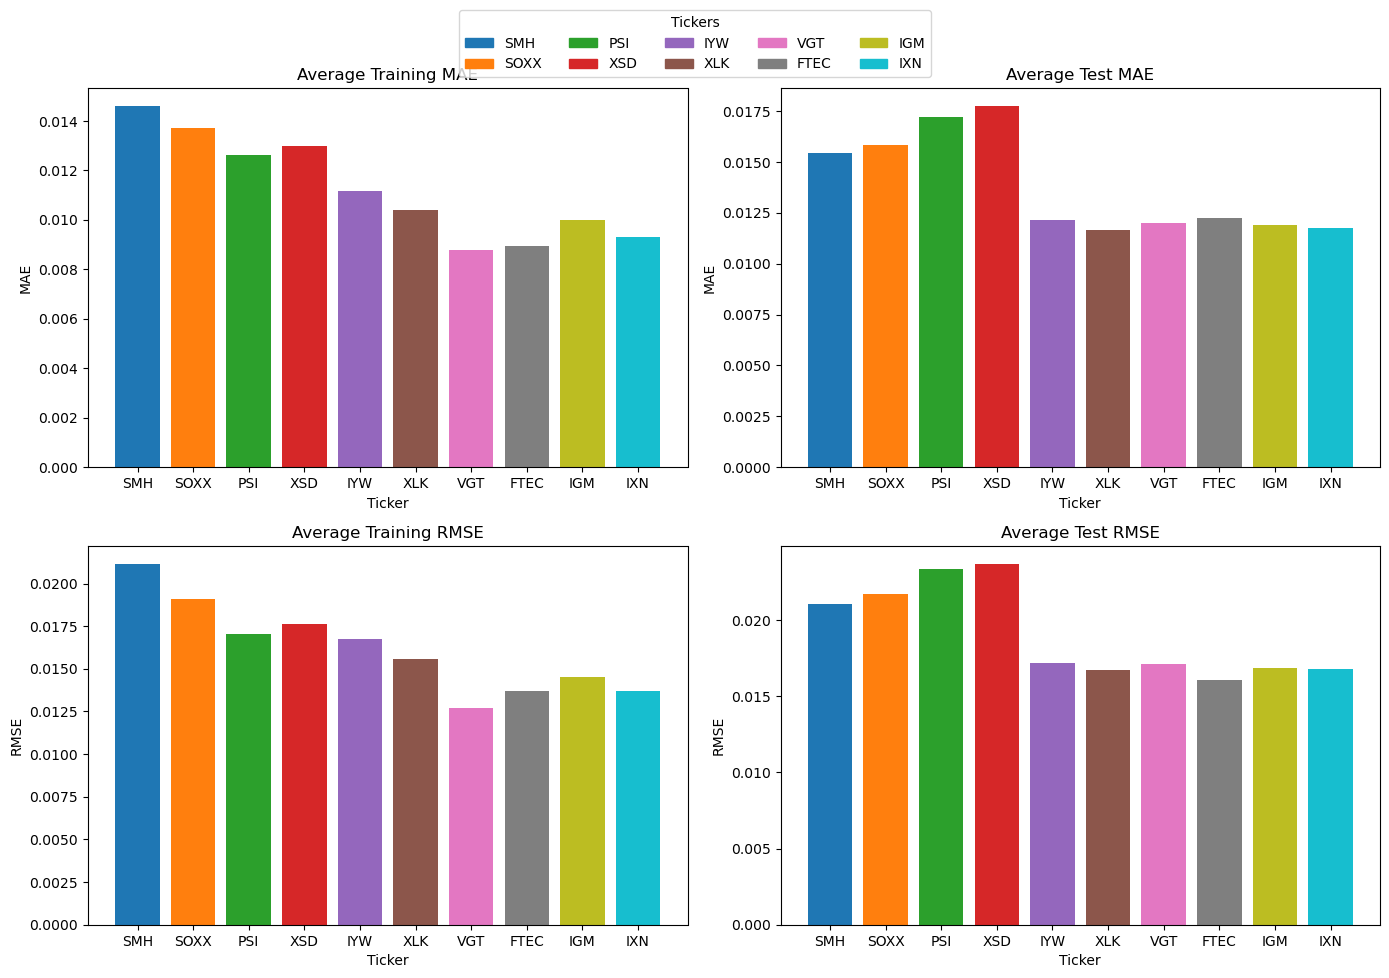

In [145]:
def plot_model_metrics(tickers, results):
    
    
    # --- 1. Gather metrics from 'results' for each ticker ---
    avg_training_mae = []
    avg_test_mae = []
    avg_training_rmse = []
    avg_test_rmse = []

    computation_time = []
    
    for ticker in tickers:
        model_metrics = results[ticker].get("model_metrics", {})
        
        train_set = model_metrics.get("training_set", {})
        test_set = model_metrics.get("test_set", {})
        
        avg_training_mae.append(train_set.get("mae", float('nan')))
        avg_test_mae.append(test_set.get("mae", float('nan')))
        avg_training_rmse.append(train_set.get("rmse", float('nan')))
        avg_test_rmse.append(test_set.get("rmse", float('nan')))

        computation_time.append(results[ticker].get("model_metrics", {}).get("time", {})) 
    
    # (Optional) Print some global averages if you want
    print("Overall mean Training MAE:", mean(avg_training_mae))
    print("Overall mean Test MAE:", mean(avg_test_mae))
    print("Overall mean Training RMSE:", mean(avg_training_rmse))
    print("Overall mean Test RMSE:", mean(avg_test_rmse))

    print(f"Total time elapsed to run the model: {sum(computation_time):.2f} seconds" )
    print(f"Average time consumed by model to train on an ETF: {mean(computation_time):.2f} seconds", )
    # --- 2. Define a color palette for each ticker (must match the number of tickers) ---
    # Example: 10 distinct colors
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    # If you have more than 10 tickers, you need more colors or a different approach.

    # --- 3. Set up a 2×2 subplot grid ---
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    x_positions = range(len(tickers))  # One position per ticker

    # --- Subplot 1: Average Training MAE ---
    ax = axs[0, 0]
    ax.bar(x_positions, avg_training_mae, color=colors[:len(tickers)])
    ax.set_title("Average Training MAE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MAE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 2: Average Test MAE ---
    ax = axs[0, 1]
    ax.bar(x_positions, avg_test_mae, color=colors[:len(tickers)])
    ax.set_title("Average Test MAE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MAE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 3: Average Training RMSE ---
    ax = axs[1, 0]
    ax.bar(x_positions, avg_training_rmse, color=colors[:len(tickers)])
    ax.set_title("Average Training RMSE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("RMSE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 4: Average Test RMSE ---
    ax = axs[1, 1]
    ax.bar(x_positions, avg_test_rmse, color=colors[:len(tickers)])
    ax.set_title("Average Test RMSE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("RMSE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- 4. Create a single legend for the entire figure ---
    legend_handles = [
        mpatches.Patch(color=c, label=ticker)
        for c, ticker in zip(colors[:len(tickers)], tickers)
    ]
    # Adjust spacing to make room at the top for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.93])

    fig.legend(
        handles=legend_handles,
        title="Tickers",
        loc="upper center",
        bbox_to_anchor=(0.5, 0.98),
        ncol=min(5, len(tickers))  # Use up to 5 columns or fewer if <5 tickers
    )

    plt.show()
plot_model_metrics(tickers, results)

In [146]:
def calculate_sharpe_ratio(returns, annual_risk_free_rate=0.1,period='daily'):
    #excess_returns = rate_of_return(returns) - risk_free_rate
    
    # Convert annual risk-free rate to daily rate
    daily_risk_free_rate = (1 + annual_risk_free_rate) ** (1/252) - 1
    
    # Calculate mean daily log return
    mean_return = np.mean(returns)
    
    # Calculate excess daily log return
    excess_return = mean_return - daily_risk_free_rate
    
    # Calculate standard deviation of daily log returns
    std_return = np.std(returns)
    
    # Print diagnostic information
    #print(f"Mean Daily Log Return: {mean_return}")
    #print(f"Excess Daily Log Return: {excess_return}")
    #print(f"Standard Deviation of Daily Log Returns: {std_return}")
    
    # Check for zero standard deviation to avoid division by zero
    epsilon = 0
    # Check for zero standard deviation to avoid division by zero
    if std_return == 0:
        epsilon = 1e-5 
    
    # Calculate Sharpe ratio
    #sharpe_ratio = (excess_return / std_return) * np.sqrt(252)  # Annualize the Sharpe ratio
    sharpe_ratio = (excess_return / (std_return +  epsilon)) # Annualize the Sharpe ratio

    return sharpe_ratio
    #return excess_returns / np.std(returns)


def calculate_rachev_ratio(returns, lower_percentile=5, upper_percentile=95):
    # Step 1: Sort the returns
    sorted_returns = np.sort(returns)
    
    # Step 2: Determine the percentiles
    lower_threshold = np.percentile(sorted_returns, lower_percentile)
    upper_threshold = np.percentile(sorted_returns, upper_percentile)
    
    # Step 3: Calculate Expected Shortfall (ES)
    es = np.mean(sorted_returns[sorted_returns <= lower_threshold])
    
    # Step 4: Calculate Expected Gain (EG)
    eg = np.mean(sorted_returns[sorted_returns >= upper_threshold])
    
    # Step 5: Compute the Rachev Ratio
    rachev_ratio = eg / -es
    return rachev_ratio


"""def calculate_volatility_clustering(returns):
    squared_returns = returns ** 2
    n = len(squared_returns)
    
    # Mean of squared returns
    mean_squared_returns = np.mean(squared_returns)
    
    # Calculate the numerator and denominator for autocorrelation at lag 1
    numerator = np.sum((squared_returns[:-1] - mean_squared_returns) * (squared_returns[1:] - mean_squared_returns))
    denominator = np.sum((squared_returns - mean_squared_returns) ** 2)
    
    if denominator == 0:
        return 0  # Avoid division by zero
    
    rho_1 = numerator / denominator
    return rho_1"""
def calculate_volatility_clustering(returns):
    # Ensure returns is a NumPy array
    returns = np.array(returns)
    squared_returns = returns ** 2
    n = len(squared_returns)

    # Mean of squared returns
    mean_squared = np.mean(squared_returns)
    clustering = np.sum((squared_returns - mean_squared) ** 2) / (n - 1 if n > 1 else 1)
    return clustering

def calculate_sortino_ratio(log_returns, target_log_return=0.04):
    """
    Calculate the Sortino Ratio using log returns.
    
    Parameters:
    - log_returns (array-like): Array or list of log returns for the period.
    - target_log_return (float): The target log return. Default is 0, which is often used as a benchmark.
    
    Returns:
    - float: The Sortino Ratio.
    """
    # Convert input to a NumPy array for easier calculations
    log_returns = np.array(log_returns)
    
    # Calculate the average period log return (R)
    avg_log_return = np.mean(log_returns)
    
    # Calculate the Target Downside Deviation (TDD)
    downside_deviation = np.sqrt(
        np.mean(np.square(np.maximum(0, target_log_return - log_returns)))
    )
    
    # Calculate Sortino Ratio
    #sortino_ratio_value = (avg_log_return - target_log_return) / downside_deviation
    epsilon = 1e-8
    
    # Add epsilon to downside_deviation to prevent division by zero
    #if downside_deviation == 0:
     #   return np.nan  # Return NaN if downside deviation is zero
    
    # Calculate Sortino Ratio
    sortino_ratio_value = (avg_log_return - target_log_return) / (downside_deviation + epsilon)
    
    return sortino_ratio_value


def compute_risk_metrics(results):
    risk_metrics_results = {}
    for ticker, data in results.items():
        risk_metrics_results[ticker] = {}
        for month in range(1, 13):
            future_predictions = data['monthly_forecast_results'][f'forecast_predictions_df_{month}m']
            
            sharpe = calculate_sharpe_ratio(future_predictions)
            rachev = calculate_rachev_ratio(future_predictions)
            volatility_clustering = calculate_volatility_clustering(future_predictions)
            sortino = calculate_sortino_ratio(future_predictions)
            
            risk_metrics_results[ticker][f'risk_metrics_{month}m'] = {
                'Sharpe Ratio': sharpe,
                'Rachev Ratio': rachev,
                'Volatility Clustering': volatility_clustering,
                'Sortino Ratio': sortino
            }
    #print(risk_metrics_results)
    return risk_metrics_results


In [147]:
def calculate_composite_score(
    forecasted_values, risk_percentage, rachev_ratio, sharpe_ratio, sortino_ratio, volatility_clustering, 
    mean_forecast, std_forecast, mean_rachev, std_rachev, mean_sharpe, std_sharpe, mean_sortino, std_sortino, 
    mean_volatility_clustering, std_volatility_clustering
):
    epsilon = 1e-8  # To prevent division by zero
    forecasted_mean = np.mean(forecasted_values)

    # Normalize the components with epsilon
    forecasted_mean_normalized = (forecasted_mean - mean_forecast) / (std_forecast + epsilon)
    rachev_normalized = (rachev_ratio - mean_rachev) / (std_rachev + epsilon)
    sharpe_normalized = (sharpe_ratio - mean_sharpe) / (std_sharpe + epsilon)
    sortino_normalized = (sortino_ratio - mean_sortino) / (std_sortino + epsilon)
    volatility_clustering_normalized = (volatility_clustering - mean_volatility_clustering) / (std_volatility_clustering + epsilon)

    # Composite score calculation
    score = (
        forecasted_mean_normalized
        - (risk_percentage * rachev_normalized)
        + sharpe_normalized
        + sortino_normalized
        - volatility_clustering_normalized
    )

    return score

def compute_composite_scores(results, risk_metrics_results, risk_percentage):
    composite_scores = {}
    
    for month in range(1, 13):
        forecasted_values = {
            ticker: data['monthly_forecast_results'][f'forecast_predictions_df_{month}m']
            for ticker, data in results.items()
        }
        
        mean_forecast = np.mean([np.mean(values) for values in forecasted_values.values()])
        std_forecast = np.std([np.mean(values) for values in forecasted_values.values()])
        
        for ticker, metrics in risk_metrics_results.items():
            risk_metrics = metrics[f'risk_metrics_{month}m']
            composite_scores.setdefault(ticker, {})[f'composite_score_{month}m'] = calculate_composite_score(
                forecasted_values[ticker], risk_percentage, risk_metrics['Rachev Ratio'], risk_metrics['Sharpe Ratio'],
                risk_metrics['Sortino Ratio'], risk_metrics['Volatility Clustering'], mean_forecast, std_forecast,
                np.mean([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()])
            )
    
    return composite_scores


In [148]:
#tickers = ['SMH', 'SOXX', 'PSI']
#results = run_workflow(tickers)
#risk_metrics_results = compute_risk_metrics(results)
#composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage=0.1)
#composite_scores

In [149]:
#portfolios

In [150]:
def select_top_etfs_monthly(df, month_label, return_scores=False):
    df_sorted = df.sort_values(by='Score', ascending=False).head(2)
    if return_scores:
        return list(df_sorted.itertuples(index=False, name=None))  # Returns tuples (ETF, Score)
    return list(df_sorted['ETF'])  # Returns only ETF names

def generate_month_ranges(start_date, end_date):
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    month_ranges = []
    while start < end:
        month_start = start
        month_end = (start + timedelta(days=31)).replace(day=1) - timedelta(days=1)
        if month_end > end:
            month_end = end
        month_ranges.append((month_start.strftime('%Y-%m-%d'), month_end.strftime('%Y-%m-%d')))
        start = month_end + timedelta(days=1)
    return month_ranges

def gather_etf_data(tickers, month_ranges):
    etf_histories = {}
    for start_date, end_date in month_ranges:
        month = f"{start_date} to {end_date}"
        etf_histories[month] = {}
        for ticker in tickers:
            etf_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            if etf_data.empty:
                print(f"No data found for {ticker} in {month}")
                continue
            etf_data.index = pd.to_datetime(etf_data.index)
            etf_histories[month][ticker] = etf_data
    return etf_histories

def initialize_shares(top_etfs, etf_histories, month, investment_amount=50000):
    ticker_shares = {}
    first_trading_day_start = month.split(" to ")[0]
    for ticker in top_etfs:
        etf_history = etf_histories.get(month, {}).get(ticker)
        if etf_history is not None:
            first_trading_day = pd.to_datetime(first_trading_day_start) + BDay(1)
            if first_trading_day not in etf_history.index:
                first_trading_day = etf_history.index[etf_history.index.searchsorted(first_trading_day)]
            price = etf_history.loc[first_trading_day, 'Close']
            num_shares = (investment_amount * 0.9975) / price
            print(f"Buy {ticker}: {num_shares:.2f} shares at {price:.2f}.")
            ticker_shares[ticker] = num_shares
        else:
            print(f"No data found for {ticker} in {month}")
    return ticker_shares

def manage_portfolio(prev_top_etfs, curr_top_etfs, prev_month, curr_month, ticker_shares, etf_histories):
    print(f"Top 2 ETFs for {prev_month}: {prev_top_etfs}")
    print(f"Top 2 ETFs for {curr_month}: {curr_top_etfs}")
    etf_histories_curr = etf_histories.get(curr_month, {})
    common_etfs = set(prev_top_etfs) & set(curr_top_etfs)
    etfs_to_sell = set(prev_top_etfs) - common_etfs
    etfs_to_buy = set(curr_top_etfs) - common_etfs
    selling_values = {}
    for etf in etfs_to_sell:
        shares = ticker_shares.pop(etf, 0)
        if shares > 0 and etf in etf_histories_curr:
            price = etf_histories_curr[etf]['Close'].iloc[0]
            selling_values[etf] = shares * price * 0.9975
            print(f"Sell {etf}: {shares:.2f} shares at {price:.2f}. Total value: {selling_values[etf]:.2f}")
    for etf_to_buy, etf_to_sell in zip(etfs_to_buy, etfs_to_sell):
        if etf_to_buy in etf_histories_curr and etf_to_sell in selling_values:
            price = etf_histories_curr[etf_to_buy]['Close'].iloc[0]
            ticker_shares[etf_to_buy] = (selling_values[etf_to_sell] * 0.9975) / price
            print(f"Buy {etf_to_buy}: {ticker_shares[etf_to_buy]:.2f} shares at {price:.2f}.")
    print(f"Updated ticker shares after {curr_month}: {ticker_shares}")
    return {etf: ticker_shares[etf] for etf in curr_top_etfs if etf in ticker_shares}

'''def portfolio(results, risk_percentage=0.2):
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage)
    portfolios = {
        str(month): select_top_etfs_monthly(
            pd.DataFrame({'ETF': list(composite_scores.keys()), 'Score': [composite_scores[t][f'composite_score_{month}m'] for t in composite_scores]}),
            f'{month}m'
        ) for month in range(1, 13)
    }
    return portfolios'''

'''def portfolio(results, risk_percentage=0.1, return_scores=False):
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage)
    
    portfolios = {
        str(month): select_top_etfs_monthly(
            pd.DataFrame({'ETF': list(composite_scores.keys()), 'Score': [composite_scores[t][f'composite_score_{month}m'] for t in composite_scores]}),
            f'{month}m',
            return_scores=return_scores
        ) for month in range(1, 13)
    }
    return portfolios
'''



"def portfolio(results, risk_percentage=0.1, return_scores=False):\n    risk_metrics_results = compute_risk_metrics(results)\n    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage)\n    \n    portfolios = {\n        str(month): select_top_etfs_monthly(\n            pd.DataFrame({'ETF': list(composite_scores.keys()), 'Score': [composite_scores[t][f'composite_score_{month}m'] for t in composite_scores]}),\n            f'{month}m',\n            return_scores=return_scores\n        ) for month in range(1, 13)\n    }\n    return portfolios\n"

In [151]:

def calculate_smoothing(scores_dict, alpha=0.1):
    smoothed_scores = {}
    previous_values = {}
    sorted_months = sorted(scores_dict.keys(), key=lambda m: int(m))
    for month in sorted_months:
        smoothed_scores[month] = {}
        for etf, raw_score in scores_dict[month].items():
            if etf not in previous_values:
                smoothed_value = float(raw_score)
            else:
                smoothed_value = alpha * float(raw_score) + (1 - alpha) * previous_values[etf]
            smoothed_scores[month][etf] = smoothed_value
            previous_values[etf] = smoothed_value
    return smoothed_scores

def portfolio(results, risk_percentage=0.2, return_scores=False):
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage)
    
    # Store all ETF scores per month instead of only top 2 ETFs
    all_scores_per_month = {
        str(month): {
            etf: composite_scores[etf][f'composite_score_{month}m']
            for etf in composite_scores
        }
        for month in range(1, 13)
    }
    
    return all_scores_per_month

def portfolio_optimization(results, risk_percentage=0.2, smoothing=False):
    all_scores = portfolio(results, risk_percentage, return_scores=True)
    print("\n--- Raw Scores Before Smoothing ---")
    for month, scores in sorted(all_scores.items(), key=lambda x: int(x[0])):
        print(f"Month {month}: {scores}")
    
    if smoothing:
        smoothed_scores = calculate_smoothing(all_scores)
        print("\n--- Smoothed Scores After Smoothing ---")
        for month, scores in sorted(smoothed_scores.items(), key=lambda x: int(x[0])):
            print(f"Month {month}: {scores}")
        
        # Use smoothed scores to select top 2 ETFs per month
        portfolios = {
            month: select_top_etfs_monthly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{month}m',
                return_scores=False
            )
            for month, scores in smoothed_scores.items()
        }
    else:
        # Select top 2 ETFs based on raw scores if no smoothing
        portfolios = {
            month: select_top_etfs_monthly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{month}m',
                return_scores=False
            )
            for month, scores in all_scores.items()
        }
    
    print("\n--- Final Portfolio Selection ---")
    for month, etfs in sorted(portfolios.items(), key=lambda x: int(x[0])):
        print(f"Month {month}: {etfs}")
    
    month_ranges = generate_month_ranges('2024-01-01', '2025-01-01')
    etf_histories = gather_etf_data(results.keys(), month_ranges)
    ticker_shares = {}
    ticker_shares_per_month = {}
    
    for i, month_range in enumerate(etf_histories.keys()):
        month_index = str(i + 1)
        top_etfs = portfolios.get(month_index, [])
        if not top_etfs:
            print(f"Warning: No ETFs selected for {month_range}. Skipping trading.")
            continue
        if i == 0:
            ticker_shares = initialize_shares(top_etfs, etf_histories, month_range)
        else:
            prev_month_index = str(i)
            prev_top_etfs = portfolios.get(prev_month_index, [])
            ticker_shares = manage_portfolio(
                prev_top_etfs,
                top_etfs,
                list(etf_histories.keys())[i - 1],
                month_range,
                ticker_shares,
                etf_histories
            )
        ticker_shares_per_month[month_range] = ticker_shares.copy()
    
    first_trading_day_13m = '2025-01-01'
    month_12_range = list(ticker_shares_per_month.keys())[-1]
    month_13_start = first_trading_day_13m
    month_13_end = '2025-01-06'
    etf_values_13m = {}
    
    if month_12_range in ticker_shares_per_month:
        ticker_shares_12m = ticker_shares_per_month[month_12_range]
        for ticker, shares in ticker_shares_12m.items():
            data = yf.download(ticker, start=month_13_start, end=month_13_end)
            if not data.empty:
                closing_price_13m = data['Close'].iloc[0]
                total_value = shares * closing_price_13m
                etf_values_13m[ticker] = total_value
    
    total_portfolio_value = sum(etf_values_13m.values()) if etf_values_13m else 0
    return ticker_shares_per_month, total_portfolio_value


In [152]:

portfolios, final_value = portfolio_optimization(results, smoothing=True)
print(f"Final Portfolio Value: {final_value:.2f}")

{'SMH': {'risk_metrics_1m': {'Sharpe Ratio': -0.8271633163259761, 'Rachev Ratio': 0.5936063725475438, 'Volatility Clustering': 1.8088380023461206e-13, 'Sortino Ratio': -0.9998937987562122}, 'risk_metrics_2m': {'Sharpe Ratio': -0.9953887699432701, 'Rachev Ratio': 0.7412360665710093, 'Volatility Clustering': 4.502456446113994e-13, 'Sortino Ratio': -0.9998316100289658}, 'risk_metrics_3m': {'Sharpe Ratio': -0.29651077535066955, 'Rachev Ratio': 1.9454347156449745, 'Volatility Clustering': 2.817400422219579e-13, 'Sortino Ratio': -0.9998931777885085}, 'risk_metrics_4m': {'Sharpe Ratio': 0.7594924443560243, 'Rachev Ratio': 6.007879936395422, 'Volatility Clustering': 5.808854100743578e-12, 'Sortino Ratio': -0.9997228445274314}, 'risk_metrics_5m': {'Sharpe Ratio': 0.6441974806687608, 'Rachev Ratio': 4.4881263178659, 'Volatility Clustering': 7.572041407073957e-11, 'Sortino Ratio': -0.9984706436161569}, 'risk_metrics_6m': {'Sharpe Ratio': -0.15198458537342055, 'Rachev Ratio': 1.349291628677006, 'V

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Buy FTEC: 356.79 shares at 139.79.
Buy PSI: 1045.38 shares at 47.71.
Top 2 ETFs for 2024-01-01 to 2024-01-31: ['FTEC', 'PSI']
Top 2 ETFs for 2024-02-01 to 2024-02-29: ['FTEC', 'PSI']
Updated ticker shares after 2024-02-01 to 2024-02-29: {'FTEC': 356.7851949024137, 'PSI': 1045.378347454883}
Top 2 ETFs for 2024-02-01 to 2024-02-29: ['FTEC', 'PSI']
Top 2 ETFs for 2024-03-01 to 2024-03-31: ['FTEC', 'PSI']
Updated ticker shares after 2024-03-01 to 2024-03-31: {'FTEC': 356.7851949024137, 'PSI': 1045.378347454883}
Top 2 ETFs for 2024-03-01 to 2024-03-31: ['FTEC', 'PSI']
Top 2 ETFs for 2024-04-01 to 2024-04-30: ['FTEC', 'PSI']
Updated ticker shares after 2024-04-01 to 2024-04-30: {'FTEC': 356.7851949024137, 'PSI': 1045.378347454883}
Top 2 ETFs for 2024-04-01 to 2024-04-30: ['FTEC', 'PSI']
Top 2 ETFs for 2024-05-01 to 2024-05-31: ['FTEC', 'PSI']
Updated ticker shares after 2024-05-01 to 2024-05-31: {'FTEC': 356.7851949024137, 'PSI': 1045.378347454883}
Top 2 ETFs for 2024-05-01 to 2024-05-31: ['

In [153]:

portfolios, final_value = portfolio_optimization(results, smoothing=False)
print(f"Final Portfolio Value: {final_value:.2f}")

{'SMH': {'risk_metrics_1m': {'Sharpe Ratio': -0.8271633163259761, 'Rachev Ratio': 0.5936063725475438, 'Volatility Clustering': 1.8088380023461206e-13, 'Sortino Ratio': -0.9998937987562122}, 'risk_metrics_2m': {'Sharpe Ratio': -0.9953887699432701, 'Rachev Ratio': 0.7412360665710093, 'Volatility Clustering': 4.502456446113994e-13, 'Sortino Ratio': -0.9998316100289658}, 'risk_metrics_3m': {'Sharpe Ratio': -0.29651077535066955, 'Rachev Ratio': 1.9454347156449745, 'Volatility Clustering': 2.817400422219579e-13, 'Sortino Ratio': -0.9998931777885085}, 'risk_metrics_4m': {'Sharpe Ratio': 0.7594924443560243, 'Rachev Ratio': 6.007879936395422, 'Volatility Clustering': 5.808854100743578e-12, 'Sortino Ratio': -0.9997228445274314}, 'risk_metrics_5m': {'Sharpe Ratio': 0.6441974806687608, 'Rachev Ratio': 4.4881263178659, 'Volatility Clustering': 7.572041407073957e-11, 'Sortino Ratio': -0.9984706436161569}, 'risk_metrics_6m': {'Sharpe Ratio': -0.15198458537342055, 'Rachev Ratio': 1.349291628677006, 'V

[*********************100%%**********************]  1 of 1 completed

Buy FTEC: 356.79 shares at 139.79.
Buy PSI: 1045.38 shares at 47.71.
Top 2 ETFs for 2024-01-01 to 2024-01-31: ['FTEC', 'PSI']
Top 2 ETFs for 2024-02-01 to 2024-02-29: ['FTEC', 'XSD']
Sell PSI: 1045.38 shares at 49.45. Total value: 51564.73
Buy XSD: 244.37 shares at 210.48.
Updated ticker shares after 2024-02-01 to 2024-02-29: {'FTEC': 356.7851949024137, 'XSD': 244.3738807019037}
Top 2 ETFs for 2024-02-01 to 2024-02-29: ['FTEC', 'XSD']
Top 2 ETFs for 2024-03-01 to 2024-03-31: ['PSI', 'XSD']
Sell FTEC: 356.79 shares at 156.77. Total value: 55793.38
Buy PSI: 983.28 shares at 56.60.
Updated ticker shares after 2024-03-01 to 2024-03-31: {'XSD': 244.3738807019037, 'PSI': 983.2844793203632}
Top 2 ETFs for 2024-03-01 to 2024-03-31: ['PSI', 'XSD']
Top 2 ETFs for 2024-04-01 to 2024-04-30: ['PSI', 'SOXX']
Sell XSD: 244.37 shares at 233.86. Total value: 57006.40
Buy SOXX: 249.08 shares at 228.30.
Updated ticker shares after 2024-04-01 to 2024-04-30: {'PSI': 983.2844793203632, 'SOXX': 249.075277851


[*********************100%%**********************]  1 of 1 completed

Final Portfolio Value: 120232.68


In [154]:
import numpy as np

def compute_risk_metrics(results):
    risk_metrics_results = {}
    for ticker, data in results.items():
        risk_metrics_results[ticker] = {}
        # Change range(1, 13) to range(1, 53) and month -> week
        for week in range(1, 54):
            # Change 'monthly_forecast_results' to 'weekly_forecast_results' 
            # and '{month}m' to '{week}w'
            future_predictions = data['weekly_forecast_results'][f'forecast_predictions_df_{week}w']
            
            sharpe = calculate_sharpe_ratio(future_predictions)
            rachev = calculate_rachev_ratio(future_predictions)
            volatility_clustering = calculate_volatility_clustering(future_predictions)
            sortino = calculate_sortino_ratio(future_predictions)
            
            # Rename 'risk_metrics_{month}m' to 'risk_metrics_{week}w'
            risk_metrics_results[ticker][f'risk_metrics_{week}w'] = {
                'Sharpe Ratio': sharpe,
                'Rachev Ratio': rachev,
                'Volatility Clustering': volatility_clustering,
                'Sortino Ratio': sortino
            }
    return risk_metrics_results

def compute_composite_scores(results, risk_metrics_results, risk_percentage):
    composite_scores = {}
    
    # Change range(1, 13) to range(1, 53) and month -> week
    for week in range(1, 54):
        forecasted_values = {
            ticker: data['weekly_forecast_results'][f'forecast_predictions_df_{week}w']
            for ticker, data in results.items()
        }
        
        mean_forecast = np.mean([np.mean(values) for values in forecasted_values.values()])
        std_forecast = np.std([np.mean(values) for values in forecasted_values.values()])
        
        for ticker, metrics in risk_metrics_results.items():
            # Rename risk_metrics_{month}m to risk_metrics_{week}w
            risk_metrics = metrics[f'risk_metrics_{week}w']
            
            # Rename composite_score_{month}m to composite_score_{week}w
            composite_scores.setdefault(ticker, {})[f'composite_score_{week}w'] = calculate_composite_score(
                forecasted_values[ticker],
                risk_percentage,
                risk_metrics['Rachev Ratio'],
                risk_metrics['Sharpe Ratio'],
                risk_metrics['Sortino Ratio'],
                risk_metrics['Volatility Clustering'],
                mean_forecast,
                std_forecast,
                np.mean([m[f'risk_metrics_{week}w']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{week}w']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{week}w']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{week}w']['Volatility Clustering'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Volatility Clustering'] for m in risk_metrics_results.values()])
            )
    
    return composite_scores


In [155]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

def select_top_etfs_weekly(df, week_label, return_scores=False):
    """
    Select the top 2 ETFs based on 'Score' for the given week_label.
    """
    df_sorted = df.sort_values(by='Score', ascending=False).head(2)
    if return_scores:
        # Returns list of tuples (ETF, Score)
        return list(df_sorted.itertuples(index=False, name=None))
    # Returns only ETF names
    return list(df_sorted['ETF'])

def generate_week_ranges(start_date, end_date):
    """
    Generate a list of weekly date ranges from start_date to end_date.
    Each range is 7 days long (e.g., Monday to Sunday).
    """
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    week_ranges = []
    
    while start < end:
        week_start = start
        # Each period is one week long (7 days)
        week_end = start + timedelta(days=6)
        # If the next 7-day block goes beyond end, truncate to end
        if week_end > end:
            week_end = end
        week_ranges.append((week_start.strftime('%Y-%m-%d'), week_end.strftime('%Y-%m-%d')))
        
        # Move to the day after week_end to start the next week
        start = week_end + timedelta(days=1)
    
    return week_ranges

def gather_etf_data_weekly(tickers, week_ranges):
    """
    Download weekly ETF data for the specified tickers over the given weekly ranges.
    Returns a dictionary keyed by 'start_date to end_date', each containing data per ticker.
    """
    etf_histories = {}
    for start_date, end_date in week_ranges:
        week = f"{start_date} to {end_date}"
        etf_histories[week] = {}
        for ticker in tickers:
            etf_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            if etf_data.empty:
                print(f"No data found for {ticker} in {week}")
                continue
            etf_data.index = pd.to_datetime(etf_data.index)
            etf_histories[week][ticker] = etf_data
    return etf_histories

def initialize_shares(top_etfs, etf_histories, week, investment_amount=50000):
    """
    Initialize shares for the top ETFs at the beginning of a given 'week'.
    """
    ticker_shares = {}
    # The 'week' string is in the format: "yyyy-mm-dd to yyyy-mm-dd"
    first_trading_day_start = week.split(" to ")[0]
    
    for ticker in top_etfs:
        etf_history = etf_histories.get(week, {}).get(ticker)
        if etf_history is not None and not etf_history.empty:
            # Move one business day forward from the week start
            first_trading_day = pd.to_datetime(first_trading_day_start) + BDay(1)
            # If this exact date isn't in the index, find the nearest future trading day
            if first_trading_day not in etf_history.index:
                idx_pos = etf_history.index.searchsorted(first_trading_day)
                if idx_pos < len(etf_history.index):
                    first_trading_day = etf_history.index[idx_pos]
                else:
                    print(f"No valid trading day found for {ticker} in {week}")
                    continue
            
            price = etf_history.loc[first_trading_day, 'Close']
            num_shares = (investment_amount * 0.9975) / price  # small friction cost (0.25%)
            print(f"Buy {ticker}: {num_shares:.2f} shares at {price:.2f}.")
            ticker_shares[ticker] = num_shares
        else:
            print(f"No data found for {ticker} in {week}")
    return ticker_shares

def manage_portfolio(prev_top_etfs, curr_top_etfs, prev_week, curr_week, ticker_shares, etf_histories):
    """
    Manage the transition from prev_week's top ETFs to curr_week's top ETFs,
    selling ETFs no longer in the top 2, and buying newly selected ETFs.
    """
    print(f"Top 2 ETFs for {prev_week}: {prev_top_etfs}")
    print(f"Top 2 ETFs for {curr_week}: {curr_top_etfs}")
    
    etf_histories_curr = etf_histories.get(curr_week, {})
    common_etfs = set(prev_top_etfs) & set(curr_top_etfs)
    etfs_to_sell = set(prev_top_etfs) - common_etfs
    etfs_to_buy = set(curr_top_etfs) - common_etfs

    selling_values = {}
    for etf in etfs_to_sell:
        shares = ticker_shares.pop(etf, 0)
        if shares > 0 and etf in etf_histories_curr and not etf_histories_curr[etf].empty:
            # Use the first available Close price in the new week to sell
            price = etf_histories_curr[etf]['Close'].iloc[0]
            selling_values[etf] = shares * price * 0.9975
            print(f"Sell {etf}: {shares:.2f} shares at {price:.2f}. Total value: {selling_values[etf]:.2f}")

    # Use zipped pairs to buy new ETFs using the proceeds from sold ETFs
    for etf_to_buy, etf_to_sell in zip(etfs_to_buy, etfs_to_sell):
        if etf_to_buy in etf_histories_curr and etf_to_sell in selling_values:
            price = etf_histories_curr[etf_to_buy]['Close'].iloc[0]
            ticker_shares[etf_to_buy] = (selling_values[etf_to_sell] * 0.9975) / price
            print(f"Buy {etf_to_buy}: {ticker_shares[etf_to_buy]:.2f} shares at {price:.2f}.")

    print(f"Updated ticker shares after {curr_week}: {ticker_shares}")
    # Return only shares for the newly selected top ETFs
    return {etf: ticker_shares[etf] for etf in curr_top_etfs if etf in ticker_shares}




In [156]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

##############################################
# Assume you already have these functions:
#   - compute_risk_metrics(results)
#   - compute_composite_scores(results, risk_metrics_results, risk_percentage)
#   - select_top_etfs_weekly()  (similar to select_top_etfs_monthly but for weeks)
#   - generate_week_ranges()
#   - gather_etf_data_weekly()
#   - initialize_shares()
#   - manage_portfolio()
##############################################

def calculate_smoothing(scores_dict, alpha=0.1):
    """
    Apply exponential smoothing to a dictionary of dictionaries containing scores.
    Keys at the top level are weeks (as strings), and values are {etf: raw_score}.
    """
    smoothed_scores = {}
    previous_values = {}
    # Sort by the numeric value of the week string (e.g., '1', '2', ..., '52')
    sorted_weeks = sorted(scores_dict.keys(), key=lambda w: int(w))
    
    for week in sorted_weeks:
        smoothed_scores[week] = {}
        for etf, raw_score in scores_dict[week].items():
            if etf not in previous_values:
                # First time seeing this ETF, just take the raw score
                smoothed_value = float(raw_score)
            else:
                # Exponential smoothing
                smoothed_value = alpha * float(raw_score) + (1 - alpha) * previous_values[etf]
            smoothed_scores[week][etf] = smoothed_value
            previous_values[etf] = smoothed_value
    
    return smoothed_scores

def portfolio_weekly(results, risk_percentage=0.1, return_scores=False):
    """
    Compute risk metrics and composite scores on a weekly basis.
    Return a dictionary of all ETF scores per week (rather than just the top 2).
    """
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage)
    
    # Collect all ETF scores per week
    # Instead of composite_score_{month}m, we use composite_score_{week}w
    all_scores_per_week = {
        str(week): {
            etf: composite_scores[etf][f'composite_score_{week}w']
            for etf in composite_scores
        }
        for week in range(1, 53)  # 1 to 52 for weeks in a year, adjust as needed
    }
    
    return all_scores_per_week

def portfolio_optimization_weekly(results, risk_percentage=0.1, smoothing=False):
    """
    High-level function to:
      - Get all raw weekly scores
      - Optionally apply smoothing
      - Select top ETFs each week
      - Manage portfolio transitions through the weeks
      - Calculate final portfolio value after a certain 'week 53' period or next horizon
    """
    # 1) Get all raw weekly scores
    all_scores = portfolio_weekly(results, risk_percentage, return_scores=True)
    
    print("\n--- Raw Scores Before Smoothing ---")
    for week, scores in sorted(all_scores.items(), key=lambda x: int(x[0])):
        print(f"Week {week}: {scores}")
    
    # 2) Optionally apply smoothing
    if smoothing:
        smoothed_scores = calculate_smoothing(all_scores)
        print("\n--- Smoothed Scores After Smoothing ---")
        for week, scores in sorted(smoothed_scores.items(), key=lambda x: int(x[0])):
            print(f"Week {week}: {scores}")
        
        # Select top 2 ETFs based on smoothed scores
        portfolios = {
            week: select_top_etfs_weekly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{week}w',
                return_scores=False
            )
            for week, scores in smoothed_scores.items()
        }
    else:
        # Select top 2 ETFs based on raw scores
        portfolios = {
            week: select_top_etfs_weekly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{week}w',
                return_scores=False
            )
            for week, scores in all_scores.items()
        }
    
    print("\n--- Final Portfolio Selection ---")
    for week, etfs in sorted(portfolios.items(), key=lambda x: int(x[0])):
        print(f"Week {week}: {etfs}")
    
    # 3) Gather weekly data for the actual buy/sell simulation
    #    Replace this range with your desired start/end for weekly intervals
    week_ranges = generate_week_ranges('2024-01-01', '2025-01-01')
    etf_histories = gather_etf_data_weekly(results.keys(), week_ranges)
    
    # Keep track of shares after each week
    ticker_shares = {}
    ticker_shares_per_week = {}
    
    # 4) Loop through the weeks in etf_histories
    for i, week_range in enumerate(etf_histories.keys()):
        week_index = str(i + 1)  # '1', '2', '3', ...
        top_etfs = portfolios.get(week_index, [])
        
        if not top_etfs:
            print(f"Warning: No ETFs selected for {week_range}. Skipping trading.")
            continue
        
        if i == 0:
            # First week: initialize shares
            ticker_shares = initialize_shares(top_etfs, etf_histories, week_range)
        else:
            # Manage portfolio transitions from previous week
            prev_week_index = str(i)
            prev_top_etfs = portfolios.get(prev_week_index, [])
            ticker_shares = manage_portfolio(
                prev_top_etfs,
                top_etfs,
                list(etf_histories.keys())[i - 1],
                week_range,
                ticker_shares,
                etf_histories
            )
        
        ticker_shares_per_week[week_range] = ticker_shares.copy()
    
    # 5) Simulate final valuation after "Week 53" or any next horizon
    #    For illustration, let's say it's a few days into 2025.
    first_trading_day_53w = '2025-01-01'
    week_52_range = list(ticker_shares_per_week.keys())[-1] if ticker_shares_per_week else None
    
    # We can define a short window for the next week:
    week_53_start = first_trading_day_53w
    week_53_end = '2025-01-06'
    etf_values_53w = {}
    
    if week_52_range and week_52_range in ticker_shares_per_week:
        ticker_shares_52w = ticker_shares_per_week[week_52_range]
        for ticker, shares in ticker_shares_52w.items():
            data = yf.download(ticker, start=week_53_start, end=week_53_end, progress=False)
            if not data.empty:
                closing_price_53w = data['Close'].iloc[0]
                total_value = shares * closing_price_53w
                etf_values_53w[ticker] = total_value
    
    total_portfolio_value = sum(etf_values_53w.values()) if etf_values_53w else 0
    
    return ticker_shares_per_week, total_portfolio_value


In [157]:

portfolios, final_value = portfolio_optimization_weekly(results, smoothing=True)
print(f"Final Portfolio Value: {final_value:.2f}")


--- Raw Scores Before Smoothing ---
Week 1: {'SMH': 2.1365322651182943, 'SOXX': -0.6387996630606639, 'PSI': -1.1581724763720997, 'XSD': 0.9625523679171685, 'IYW': -3.1210230552464173, 'XLK': -1.7104362733752312, 'VGT': 0.09367508374343043, 'FTEC': 3.9251897972334757, 'IGM': -0.48786823962564024, 'IXN': -0.0016498062224133065}
Week 2: {'SMH': 1.7529503550746726, 'SOXX': -0.4505447066109608, 'PSI': -0.32848023472147125, 'XSD': 1.2430843995323548, 'IYW': -3.045708408013418, 'XLK': -1.5286160037997925, 'VGT': 0.29837121375648573, 'FTEC': 3.1944330602491404, 'IGM': -0.9064129130966952, 'IXN': -0.22907676238070168}
Week 3: {'SMH': -0.0657390885896287, 'SOXX': 0.6492501024183748, 'PSI': 1.478833727900722, 'XSD': -0.17399025129096343, 'IYW': -2.5985878645186222, 'XLK': -2.216049701581705, 'VGT': -0.07637056858996322, 'FTEC': 3.869024548710922, 'IGM': -0.4370353687780706, 'IXN': -0.42933553568851845}
Week 4: {'SMH': 0.9310248696870035, 'SOXX': 1.9181399569631563, 'PSI': 2.4199543432610944, 'XS

Buy FTEC: 356.79 shares at 139.79.
Buy SMH: 295.17 shares at 168.97.
Top 2 ETFs for 2024-01-01 to 2024-01-07: ['FTEC', 'SMH']
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['FTEC', 'SMH']
Updated ticker shares after 2024-01-08 to 2024-01-14: {'FTEC': 356.7851949024137, 'SMH': 295.17073823568774}
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['FTEC', 'SMH']
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['FTEC', 'SMH']
Updated ticker shares after 2024-01-15 to 2024-01-21: {'FTEC': 356.7851949024137, 'SMH': 295.17073823568774}
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['FTEC', 'SMH']
Top 2 ETFs for 2024-01-22 to 2024-01-28: ['FTEC', 'SMH']
Updated ticker shares after 2024-01-22 to 2024-01-28: {'FTEC': 356.7851949024137, 'SMH': 295.17073823568774}
Top 2 ETFs for 2024-01-22 to 2024-01-28: ['FTEC', 'SMH']
Top 2 ETFs for 2024-01-29 to 2024-02-04: ['FTEC', 'SMH']
Updated ticker shares after 2024-01-29 to 2024-02-04: {'FTEC': 356.7851949024137, 'SMH': 295.17073823568774}
Top 2 ETFs for 2024-01-29 to 2024-02-04

Final Portfolio Value: 120676.31


In [158]:

portfolios, final_value = portfolio_optimization_weekly(results, smoothing=False)
print(f"Final Portfolio Value: {final_value:.2f}")


--- Raw Scores Before Smoothing ---
Week 1: {'SMH': 2.1365322651182943, 'SOXX': -0.6387996630606639, 'PSI': -1.1581724763720997, 'XSD': 0.9625523679171685, 'IYW': -3.1210230552464173, 'XLK': -1.7104362733752312, 'VGT': 0.09367508374343043, 'FTEC': 3.9251897972334757, 'IGM': -0.48786823962564024, 'IXN': -0.0016498062224133065}
Week 2: {'SMH': 1.7529503550746726, 'SOXX': -0.4505447066109608, 'PSI': -0.32848023472147125, 'XSD': 1.2430843995323548, 'IYW': -3.045708408013418, 'XLK': -1.5286160037997925, 'VGT': 0.29837121375648573, 'FTEC': 3.1944330602491404, 'IGM': -0.9064129130966952, 'IXN': -0.22907676238070168}
Week 3: {'SMH': -0.0657390885896287, 'SOXX': 0.6492501024183748, 'PSI': 1.478833727900722, 'XSD': -0.17399025129096343, 'IYW': -2.5985878645186222, 'XLK': -2.216049701581705, 'VGT': -0.07637056858996322, 'FTEC': 3.869024548710922, 'IGM': -0.4370353687780706, 'IXN': -0.42933553568851845}
Week 4: {'SMH': 0.9310248696870035, 'SOXX': 1.9181399569631563, 'PSI': 2.4199543432610944, 'XS

Buy FTEC: 356.79 shares at 139.79.
Buy SMH: 295.17 shares at 168.97.
Top 2 ETFs for 2024-01-01 to 2024-01-07: ['FTEC', 'SMH']
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['FTEC', 'SMH']
Updated ticker shares after 2024-01-08 to 2024-01-14: {'FTEC': 356.7851949024137, 'SMH': 295.17073823568774}
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['FTEC', 'SMH']
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['FTEC', 'PSI']
Sell SMH: 295.17 shares at 175.70. Total value: 51731.84
Buy PSI: 1081.59 shares at 47.71.
Updated ticker shares after 2024-01-15 to 2024-01-21: {'FTEC': 356.7851949024137, 'PSI': 1081.5869931412365}
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['FTEC', 'PSI']
Top 2 ETFs for 2024-01-22 to 2024-01-28: ['FTEC', 'PSI']
Updated ticker shares after 2024-01-22 to 2024-01-28: {'FTEC': 356.7851949024137, 'PSI': 1081.5869931412365}
Top 2 ETFs for 2024-01-22 to 2024-01-28: ['FTEC', 'PSI']
Top 2 ETFs for 2024-01-29 to 2024-02-04: ['FTEC', 'SMH']
Sell PSI: 1081.59 shares at 50.79. Total value: 54796.47


Final Portfolio Value: 109242.31
